# Assignment : DT

In [2]:
import pandas as pd
import pickle
import nltk
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm_notebook #https://www.analyticsvidhya.com/blog/2021/05/how-to-use-progress-bars-in-python/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from wordcloud import WordCloud, STOPWORDS

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import plotly.offline as offline
import  plotly.graph_objs as go
offline.init_notebook_mode()

In [7]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# <font color="blue">A - Loading Data</b></font>

In [3]:
Data = pd.read_csv('preprocessed_data.csv')

In [4]:
Data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')

# <font color="blue">B- Calculate Sentiment Scores for the essay feature</b></font>

In [8]:
sid = SentimentIntensityAnalyzer()
Negative,Neutral,Positive,Compound = [],[],[],[]
for text in tqdm_notebook(Data['essay']):
    ss = sid.polarity_scores(text)
    Negative.append(ss['neg'])
    Neutral.append(ss['neu'])
    Positive.append(ss['pos'])
    Compound.append(ss['compound'])

  0%|          | 0/109248 [00:00<?, ?it/s]

In [9]:
Data['neg'] = Negative
Data['neu'] = Neutral
Data['pos'] = Positive
Data['compound'] = Compound

# <font color="blue">C - Split your data</b></font>

In [10]:
y = Data['project_is_approved'].values
y.shape

(109248,)

In [11]:
x = Data.drop(['project_is_approved'],axis = 1)
x.shape

(109248, 12)

In [12]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33,stratify=y,random_state=42,shuffle=True)

In [13]:
print("x_train shape:",x_train.shape)
print("y_train shape:",y_train.shape)
print("------------------------")
print("x_test shape:",x_test.shape)
print("y_test shape:",y_test.shape)

x_train shape: (73196, 12)
y_train shape: (73196,)
------------------------
x_test shape: (36052, 12)
y_test shape: (36052,)


# <font color="blue">D - Perform TFIDF Vectorization of text data (essay)</b></font>

In [14]:
vectorizer_tfidf = TfidfVectorizer(min_df=10)
vectorizer_tfidf.fit(x_train['essay'].values) # fit has to happen only on train data

TfidfVectorizer(min_df=10)

In [15]:
essay_tfidf_x_train = vectorizer_tfidf.transform(x_train['essay'].values)
essay_tfidf_x_test = vectorizer_tfidf.transform(x_test['essay'].values)

In [16]:
print(essay_tfidf_x_train.shape)
print(essay_tfidf_x_test.shape)

(73196, 14266)
(36052, 14266)


# <font color="blue">E - Perform w2v vectorization of text data</b></font>

In [17]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

# <font color="orange">I - Avg w2v</b></font>

In [18]:
# average Word2Vec
# compute average word2vec for each review.
train_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm_notebook(x_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    train_avg_w2v_vectors.append(vector)

print(len(train_avg_w2v_vectors))
print(len(train_avg_w2v_vectors[0]))

  0%|          | 0/73196 [00:00<?, ?it/s]

73196
300


In [19]:
# average Word2Vec
# compute average word2vec for each review.
test_avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm_notebook(x_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_avg_w2v_vectors.append(vector)

print(len(test_avg_w2v_vectors))
print(len(test_avg_w2v_vectors[0]))

  0%|          | 0/36052 [00:00<?, ?it/s]

36052
300


# <font color="orange">II - TFIDF weighted W2V</b></font>

In [20]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(x_train['essay'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [21]:
# TFIDF weighted W2V
# compute average word2vec for each review.
train_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm_notebook(x_train['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    train_tfidf_w2v_vectors.append(vector)

print(len(train_tfidf_w2v_vectors))
print(len(train_tfidf_w2v_vectors[0]))

  0%|          | 0/73196 [00:00<?, ?it/s]

73196
300


In [22]:
# TFIDF weighted W2V
# compute average word2vec for each review.
test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm_notebook(x_test['essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_tfidf_w2v_vectors.append(vector)

print(len(test_tfidf_w2v_vectors))
print(len(test_tfidf_w2v_vectors[0]))

  0%|          | 0/36052 [00:00<?, ?it/s]

36052
300


# <font color="blue">F - Perform Encoding of Categorical Features</b></font>

# <font color="orange">State State</b></font>

In [23]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(x_train['school_state'].values) # fit has to happen only on train data

CountVectorizer(binary=True)

In [24]:
# we use the fitted CountVectorizer to convert the text to vector
OHE_X_train_state = vectorizer.transform(x_train['school_state'].values)
OHE_X_test_state = vectorizer.transform(x_test['school_state'].values)

In [25]:
print("OHE_X_train_state:",OHE_X_train_state.shape)
print("OHE_X_test_state:",OHE_X_test_state.shape)

OHE_X_train_state: (73196, 51)
OHE_X_test_state: (36052, 51)


# <font color="orange">Teacher Prefix</b></font>

In [26]:
vectorizer = CountVectorizer(binary=True)
vectorizer.fit(x_train['teacher_prefix'].values) # fit has to happen only on train data

CountVectorizer(binary=True)

In [27]:
# we use the fitted CountVectorizer to convert the text to vector
OHE_X_train_teacher_prefix = vectorizer.transform(x_train['teacher_prefix'].values)
OHE_X_test_teacher_prefix = vectorizer.transform(x_test['teacher_prefix'].values)

In [28]:
print("OHE_X_train_teacher_prefix:",OHE_X_train_teacher_prefix.shape)
print("OHE_X_test_teacher_prefix:",OHE_X_test_teacher_prefix.shape)

OHE_X_train_teacher_prefix: (73196, 5)
OHE_X_test_teacher_prefix: (36052, 5)


# <font color="orange">Project Grade Category</b></font>

In [29]:
vertorizer = CountVectorizer(binary=True)
vectorizer.fit(x_train['project_grade_category'].values)

CountVectorizer(binary=True)

In [30]:
# we use the fitted CountVectorizer to convert the text to vector
OHE_X_train_grade_catagory = vectorizer.transform(x_train['project_grade_category'].values)
OHE_X_test_grade_catagory = vectorizer.transform(x_test['project_grade_category'].values)

In [31]:
print("OHE_X_train_grade_catagory:",OHE_X_train_grade_catagory.shape)
print("OHE_X_test_grade_catagory:",OHE_X_test_grade_catagory.shape)

OHE_X_train_grade_catagory: (73196, 4)
OHE_X_test_grade_catagory: (36052, 4)


# <font color="orange">Clean Categories</b></font>

In [32]:
vertorizer = CountVectorizer(binary=True)
vectorizer.fit(x_train['clean_categories'].values)

CountVectorizer(binary=True)

In [33]:
# we use the fitted CountVectorizer to convert the text to vector
OHE_X_train_clean_categories = vectorizer.transform(x_train['clean_categories'].values)
OHE_X_test_clean_categories= vectorizer.transform(x_test['clean_categories'].values)

In [34]:
print("OHE_X_train_clean_categories:",OHE_X_train_clean_categories.shape)
print("OHE_X_test_clean_categories:",OHE_X_test_clean_categories.shape)

OHE_X_train_clean_categories: (73196, 9)
OHE_X_test_clean_categories: (36052, 9)


# <font color="orange">clean Subcategories</b></font>

In [35]:
vertorizer = CountVectorizer(binary=True)
vectorizer.fit(x_train['clean_subcategories'].values)

CountVectorizer(binary=True)

In [36]:
# we use the fitted CountVectorizer to convert the text to vector
OHE_X_train_clean_subcategories = vectorizer.transform(x_train['clean_subcategories'].values)
OHE_X_test_clean_subcategories= vectorizer.transform(x_test['clean_subcategories'].values)

In [37]:
print("OHE_X_train_clean_subcategories:",OHE_X_train_clean_subcategories.shape)
print("OHE_X_test_clean_subcategories:",OHE_X_test_clean_subcategories.shape)

OHE_X_train_clean_subcategories: (73196, 30)
OHE_X_test_clean_subcategories: (36052, 30)


# <font color="blue">G - Perform Encoding of Numerical Features</b></font>

# <font color="orange">Teacher Number of Previously Posted Projects</b></font>

In [38]:
scaler = StandardScaler()
scaler.fit(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

StandardScaler()

In [39]:
scaler_X_train_teacher_number_of_previously_posted_projects = scaler.transform(x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))
scaler_X_test_teacher_number_of_previously_posted_projects = scaler.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1))

In [40]:
print("scaler_X_train_teacher_number_of_previously_posted_projects:",scaler_X_train_teacher_number_of_previously_posted_projects.shape)
print("scaler_X_test_teacher_number_of_previously_posted_projects:",scaler_X_test_teacher_number_of_previously_posted_projects.shape)

scaler_X_train_teacher_number_of_previously_posted_projects: (73196, 1)
scaler_X_test_teacher_number_of_previously_posted_projects: (36052, 1)


# <font color="orange">Price</b></font>


In [41]:
scaler = StandardScaler()
scaler.fit(x_train['price'].values.reshape(-1,1))

StandardScaler()

In [42]:
scaler_X_train_price = scaler.transform(x_train['price'].values.reshape(-1,1))
scaler_X_test_price = scaler.transform(x_test['price'].values.reshape(-1,1))

In [43]:
print("scaler_X_train_price:",scaler_X_train_price.shape)
print("scaler_X_test_price:",scaler_X_test_price.shape)

scaler_X_train_price: (73196, 1)
scaler_X_test_price: (36052, 1)


# <font color="orange">Negative Sentiment Scores</b></font>

In [44]:
scaler = StandardScaler()
scaler.fit(x_train['neg'].values.reshape(-1,1))

StandardScaler()

In [45]:
scaler_X_train_NSS = scaler.transform(x_train['neg'].values.reshape(-1,1))
scaler_X_test_NSS = scaler.transform(x_test['neg'].values.reshape(-1,1))

In [46]:
print("scaler_X_train_NSS:",scaler_X_train_NSS.shape)
print("scaler_X_test_NSS:",scaler_X_test_NSS.shape)

scaler_X_train_NSS: (73196, 1)
scaler_X_test_NSS: (36052, 1)


# <font color="orange">Neutral Sentiment Scores</b></font>

In [47]:
scaler = StandardScaler()
scaler.fit(x_train['neu'].values.reshape(-1,1))

StandardScaler()

In [48]:
scaler_X_train_NUSS = scaler.transform(x_train['neu'].values.reshape(-1,1))
scaler_X_test_NUSS = scaler.transform(x_test['neu'].values.reshape(-1,1))

In [49]:
print("scaler_X_train_NUSS:",scaler_X_train_NUSS.shape)
print("scaler_X_test_NUSS:",scaler_X_test_NUSS.shape)

scaler_X_train_NUSS: (73196, 1)
scaler_X_test_NUSS: (36052, 1)


# <font color="orange">Positive Sentiment Scores</b></font>

In [50]:
scaler = StandardScaler()
scaler.fit(x_train['pos'].values.reshape(-1,1))

StandardScaler()

In [51]:
scaler_X_train_PSS = scaler.transform(x_train['pos'].values.reshape(-1,1))
scaler_X_test_PSS = scaler.transform(x_test['pos'].values.reshape(-1,1))

In [52]:
print("scaler_X_train_PSS:",scaler_X_train_PSS.shape)
print("scaler_X_test_PSS:",scaler_X_test_PSS.shape)

scaler_X_train_PSS: (73196, 1)
scaler_X_test_PSS: (36052, 1)


# <font color="orange">Compound  Sentiment Scores</b></font>

In [53]:
scaler = StandardScaler()
scaler.fit(x_train['compound'].values.reshape(-1,1))

StandardScaler()

In [54]:
scaler_X_train_CSS = scaler.transform(x_train['compound'].values.reshape(-1,1))
scaler_X_test_CSS = scaler.transform(x_test['compound'].values.reshape(-1,1))

In [55]:
print("scaler_X_train_CSS:",scaler_X_train_CSS.shape)
print("scaler_X_test_CSS:",scaler_X_test_CSS.shape)

scaler_X_train_CSS: (73196, 1)
scaler_X_test_CSS: (36052, 1)


# <font color="blue">G - For Task-1 Set-1 (TFIDF) stack up all the features</b></font>

In [56]:
train_set_1 = hstack((essay_tfidf_x_train, OHE_X_train_state, OHE_X_train_teacher_prefix, OHE_X_train_grade_catagory, 
                     OHE_X_train_clean_categories,OHE_X_train_clean_subcategories, scaler_X_train_teacher_number_of_previously_posted_projects,
                     scaler_X_train_price, scaler_X_train_NSS, scaler_X_train_NUSS, scaler_X_train_PSS, scaler_X_train_CSS)).tocsr()
print(train_set_1.shape,  y_train.shape)

(73196, 14371) (73196,)


In [57]:
test_set_1 = hstack((essay_tfidf_x_test, OHE_X_test_state, OHE_X_test_teacher_prefix, OHE_X_test_grade_catagory, 
                     OHE_X_test_clean_categories,OHE_X_test_clean_subcategories, scaler_X_test_teacher_number_of_previously_posted_projects,
                     scaler_X_test_price, scaler_X_test_NSS, scaler_X_test_NUSS, scaler_X_test_PSS, scaler_X_test_CSS)).tocsr()

print(test_set_1.shape,  y_test.shape)

(36052, 14371) (36052,)


# <font color="blue">H - For Task-1 Set-2 (TFIDF_w2v) stack up all the features</b></font>

In [58]:
train_set_2 = hstack((train_tfidf_w2v_vectors, OHE_X_train_state, OHE_X_train_teacher_prefix, OHE_X_train_grade_catagory, 
                     OHE_X_train_clean_categories,OHE_X_train_clean_subcategories, scaler_X_train_teacher_number_of_previously_posted_projects,
                     scaler_X_train_price, scaler_X_train_NSS, scaler_X_train_NUSS, scaler_X_train_PSS, scaler_X_train_CSS)).tocsr()
print(train_set_2.shape,  y_train.shape)

(73196, 405) (73196,)


In [59]:
test_set_2 = hstack((test_tfidf_w2v_vectors, OHE_X_test_state, OHE_X_test_teacher_prefix, OHE_X_test_grade_catagory, 
                     OHE_X_test_clean_categories,OHE_X_test_clean_subcategories, scaler_X_test_teacher_number_of_previously_posted_projects,
                     scaler_X_test_price, scaler_X_test_NSS, scaler_X_test_NUSS, scaler_X_test_PSS, scaler_X_test_CSS)).tocsr()

print(test_set_2.shape,  y_test.shape)

(36052, 405) (36052,)


# <font color="blue">I - Perform Hyperparameter Tuning & Plot either Heatmap or 3d Plot</b></font>

# <font color='red'> <b>Task - 1</b></font>

# <font color='green'> <b>Set - 1</b></font>

In [60]:
param_grid = {'max_depth':[1,3,10,30],'min_samples_split':[5,10,100,500]}

In [61]:
DT = DecisionTreeClassifier()

In [62]:
search = GridSearchCV(DT, param_grid, n_jobs=-1, scoring="roc_auc", cv=3, return_train_score=True)
search.fit(train_set_1,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [63]:
estimator = search.best_estimator_
print("Best Estimator:",estimator)

Best Estimator: DecisionTreeClassifier(max_depth=10, min_samples_split=500)


In [64]:
score = search.best_score_
print("Best Score:",score)

Best Score: 0.6444997372575579


In [65]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
result = search.cv_results_
mean_train_score = result["mean_train_score"]
mean_test_score  = result['mean_test_score']
print("mean_train_score:",mean_train_score)
print("----------------------------------------------------")
print("mean_test_score:",mean_test_score)

mean_train_score: [0.54937496 0.54937496 0.54937496 0.54937496 0.6091472  0.6091472
 0.6091472  0.6091472  0.70604193 0.70516132 0.70083849 0.69438828
 0.85450947 0.84926587 0.8211391  0.78749895]
----------------------------------------------------
mean_test_score: [0.54847504 0.54847504 0.54847504 0.54847504 0.60196747 0.60196747
 0.60196747 0.60196747 0.63553778 0.63604691 0.63996102 0.64449974
 0.56291083 0.57539338 0.60335215 0.63178284]


In [66]:
x = param_grid['max_depth']
y = param_grid['min_samples_split']
train_auc_z = mean_train_score
test_auc_z = mean_test_score

In [68]:
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids
values_heatmap = pd.DataFrame(search.cv_results_)
values_heatmap = values_heatmap.groupby(['param_max_depth','param_min_samples_split']).max()
values_heatmap = values_heatmap.unstack()[['mean_test_score', 'mean_train_score']]
values_heatmap.head()

mean_test_score                                \
param_min_samples_split             5         10        100       500   
param_max_depth                                                         
1                              0.548475  0.548475  0.548475  0.548475   
3                              0.601967  0.601967  0.601967  0.601967   
10                             0.635538  0.636047  0.639961  0.644500   
30                             0.562911  0.575393  0.603352  0.631783   

                        mean_train_score                                
param_min_samples_split              5         10        100       500  
param_max_depth                                                         
1                               0.549375  0.549375  0.549375  0.549375  
3                               0.609147  0.609147  0.609147  0.609147  
10                              0.706042  0.705161  0.700838  0.694388  
30                              0.854509  0.849266  0.821139  0.787499

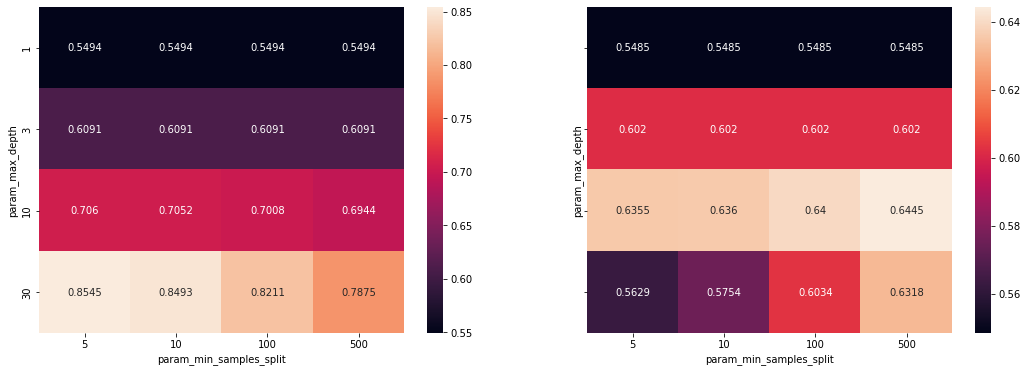

In [69]:
# https://stackoverflow.com/questions/56478320/how-to-create-multiple-seaborn-heatmaps-with-a-shared-legend-in-one-figure
fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(18,6))
sn.heatmap(values_heatmap.mean_train_score, annot=True, fmt='.4g',ax=ax[0]);
sn.heatmap(values_heatmap.mean_test_score, annot=True, fmt='.4g',ax=ax[1]);
plt.show()

# <font color="Black">Using the Best Parameters, fit the model. Plot ROC-AUC curve(using predict proba method)</b></font>

In [70]:
clf = DecisionTreeClassifier(max_depth=search.best_params_['max_depth'],
                              min_samples_split=search.best_params_['min_samples_split'])

In [71]:
clf.fit(train_set_1,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=500)

In [72]:
train_value = clf.predict_proba(train_set_1)
train_set_1_y = train_value[:,1]
print("train_set_1_y:",train_set_1_y.shape)
test_value = clf.predict_proba(test_set_1)
test_set_1_y = test_value[:,1]
print("test_set_1_y:",test_set_1_y.shape)

train_set_1_y: (73196,)
test_set_1_y: (36052,)


In [73]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_train,train_set_1_y)
Train_AUC = auc(train_fpr, train_tpr)
print("Train AUC:",Train_AUC)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test,test_set_1_y)
Test_AUC = auc(test_fpr, test_tpr)
print("Test AUC:",Test_AUC)

Train AUC: 0.6906169806654935
Test AUC: 0.6523688468568721


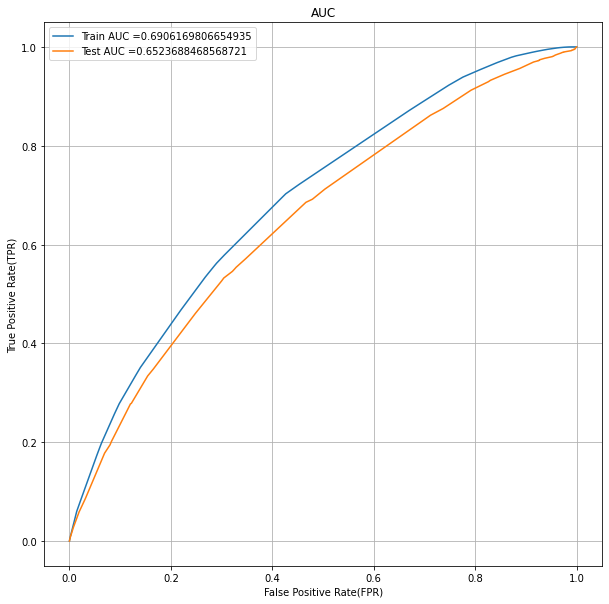

In [74]:
plt.figure(figsize=(10,10))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(Train_AUC))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(Test_AUC))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

# <font color='black'><b>Plot confusion matrix based on best threshold value</b></font>

In [75]:
from sklearn.metrics import confusion_matrix

# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [76]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(train_set_1_y, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_set_1_y, best_t)))

the maximum value of tpr*(1-fpr) 0.403903064681679 for threshold 0.852
Train confusion matrix
[[ 6437  4646]
 [18918 43195]]
Test confusion matrix
[[ 2914  2545]
 [ 9621 20972]]


Train confusion matrix


Text(33.0, 0.5, 'True')

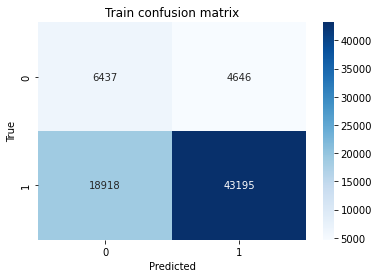

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Train confusion matrix")
plt.title("Train confusion matrix")
sns.heatmap((confusion_matrix(y_train, predict_with_best_t(train_set_1_y, best_t))), annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")

Test confusion matrix


Text(33.0, 0.5, 'True')

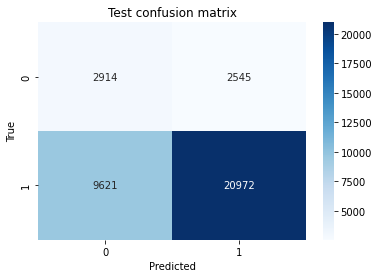

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Test confusion matrix")
plt.title("Test confusion matrix")
sns.heatmap((confusion_matrix(y_test, predict_with_best_t(test_set_1_y, best_t))), annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")

# <font color='black'> <b>Find all the false positive data points and plot wordcloud of essay text and pdf of teacher_number_of_previously_posted_projects.</b></font>

In [79]:
predict_values = predict_with_best_t(test_set_1_y,best_t)

In [80]:
false_pos = []
for x in range(len(y_test)):
    if((y_test[x]==0) and (predict_values[x]==1)):
        false_pos.append(x)  
print("false_pos_shape:",len(false_pos))

false_pos_shape: 2545


In [81]:
features = x_test.columns
false_pos_ds = pd.DataFrame(columns=features)
false_pos_ds = x_test.iloc[false_pos]
print("False_pos_ds:",false_pos_ds.shape)

False_pos_ds: (2545, 12)


# <font color='black'> <b>Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points</b></font>

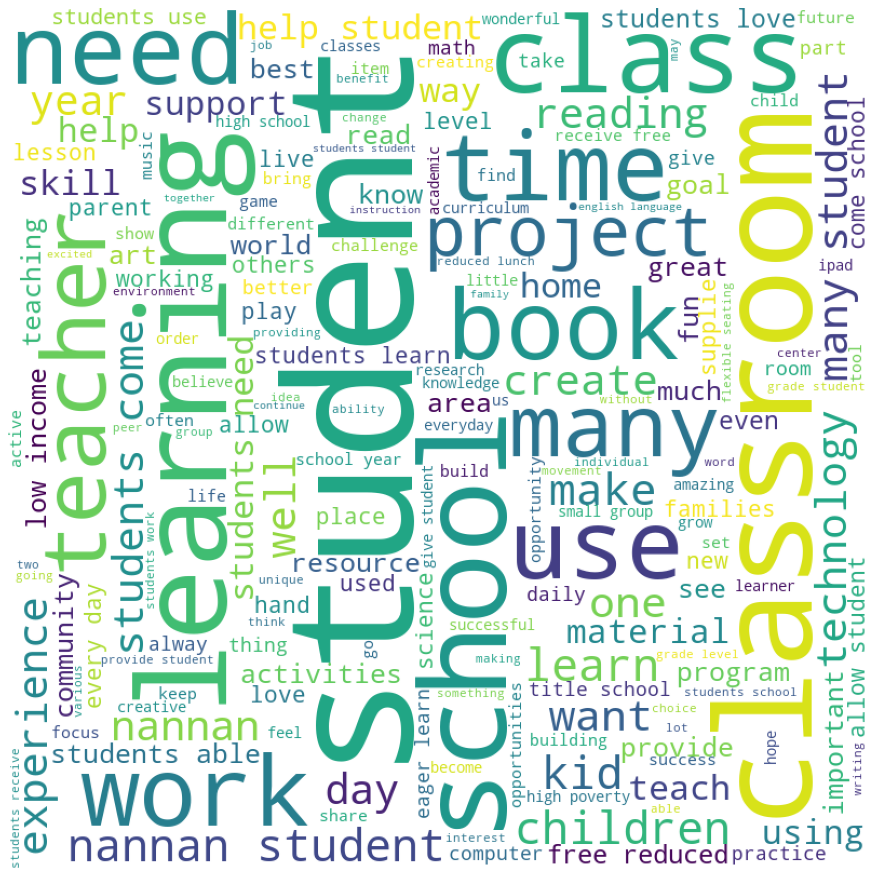

In [82]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ''
stopwords = set(STOPWORDS)
for val in false_pos_ds['essay']: 
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# <font color='black'> <b>Plot the box plot with the `price` of these `false positive data points`</b></font>

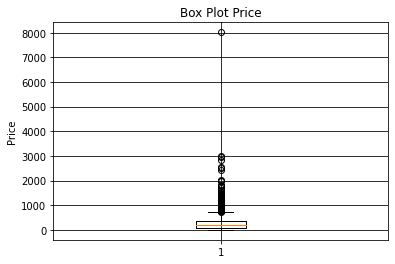

In [83]:
data = false_pos_ds['price']
plt.title("Box Plot Price")
plt.boxplot(data)
plt.grid(True)
plt.ylabel('Price')
plt.show()

# <font color='black'> <b>Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</b></font>

[8.65618861e-01 8.33005894e-02 2.43614931e-02 9.82318271e-03
 8.25147348e-03 3.14341847e-03 3.14341847e-03 1.17878193e-03
 3.92927308e-04 7.85854617e-04]


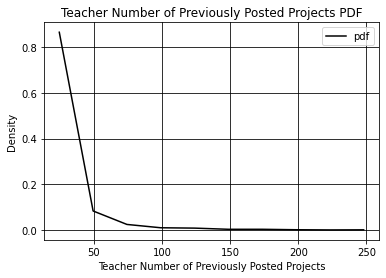

In [84]:
counts, bin_edges = np.histogram(false_pos_ds['teacher_number_of_previously_posted_projects'], bins=10,density = True)
pdf = counts/(sum(counts))
print(pdf)
plt.plot(bin_edges[1:],pdf,label = 'pdf',color='black')
plt.title("Teacher Number of Previously Posted Projects PDF")
plt.grid(True)
plt.xlabel("Teacher Number of Previously Posted Projects")
plt.ylabel("Density")
plt.legend()

# <font color='black'> <b>-----------------------------------------------------------------------------------------------------------------</b></font>
# <font color='black'> <b>-----------------------------------------------------------------------------------------------------------------</b></font>

# <font color='green'> <b>Set - 2</b></font>

In [85]:
train_set_2 = hstack((train_tfidf_w2v_vectors, OHE_X_train_state, OHE_X_train_teacher_prefix, OHE_X_train_grade_catagory, 
                     OHE_X_train_clean_categories,OHE_X_train_clean_subcategories, scaler_X_train_teacher_number_of_previously_posted_projects,
                     scaler_X_train_price, scaler_X_train_NSS, scaler_X_train_NUSS, scaler_X_train_PSS, scaler_X_train_CSS)).tocsr()
print(train_set_2.shape,  y_train.shape)

(73196, 405) (73196,)


In [86]:
test_set_2 = hstack((test_tfidf_w2v_vectors, OHE_X_test_state, OHE_X_test_teacher_prefix, OHE_X_test_grade_catagory, 
                     OHE_X_test_clean_categories,OHE_X_test_clean_subcategories, scaler_X_test_teacher_number_of_previously_posted_projects,
                     scaler_X_test_price, scaler_X_test_NSS, scaler_X_test_NUSS, scaler_X_test_PSS, scaler_X_test_CSS)).tocsr()

print(test_set_2.shape,  y_test.shape)

(36052, 405) (36052,)


In [87]:
param_grid = {'max_depth':[1,3,10,30],'min_samples_split':[5,10,100,500]}

In [88]:
search = GridSearchCV(DT, param_grid, n_jobs=-1, scoring="roc_auc", cv=3, return_train_score=True)
search.fit(train_set_2,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [89]:
estimator = search.best_estimator_
print("Best Estimator:",estimator)

Best Estimator: DecisionTreeClassifier(max_depth=10, min_samples_split=500)


In [90]:
score = search.best_score_
print("Best Score:",score)

Best Score: 0.6270240938739212


In [91]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
result = search.cv_results_
mean_train_score = result["mean_train_score"]
mean_test_score  = result['mean_test_score']
print("mean_train_score:",mean_train_score)
print("----------------------------------------------------")
print("mean_test_score:",mean_test_score)

mean_train_score: [0.55961343 0.55961343 0.55961343 0.55961343 0.62181246 0.62181246
 0.62181246 0.62181246 0.76814424 0.76600393 0.7487139  0.72362014
 0.99576362 0.99171946 0.91868122 0.78320164]
----------------------------------------------------
mean_test_score: [0.55685778 0.55685778 0.55685778 0.55685778 0.61195749 0.61195749
 0.61195749 0.61195749 0.60928079 0.6106834  0.61800101 0.62702409
 0.50837454 0.51455788 0.56721786 0.61566837]


In [92]:
x = param_grid['max_depth']
y = param_grid['min_samples_split']
train_auc_z = mean_train_score
test_auc_z = mean_test_score

In [94]:
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids
values_heatmap = pd.DataFrame(search.cv_results_)
values_heatmap = values_heatmap.groupby(['param_max_depth','param_min_samples_split']).max()
values_heatmap = values_heatmap.unstack()[['mean_test_score', 'mean_train_score']]
values_heatmap.head()

mean_test_score                                \
param_min_samples_split             5         10        100       500   
param_max_depth                                                         
1                              0.556858  0.556858  0.556858  0.556858   
3                              0.611957  0.611957  0.611957  0.611957   
10                             0.609281  0.610683  0.618001  0.627024   
30                             0.508375  0.514558  0.567218  0.615668   

                        mean_train_score                                
param_min_samples_split              5         10        100       500  
param_max_depth                                                         
1                               0.559613  0.559613  0.559613  0.559613  
3                               0.621812  0.621812  0.621812  0.621812  
10                              0.768144  0.766004  0.748714  0.723620  
30                              0.995764  0.991719  0.918681  0.783202

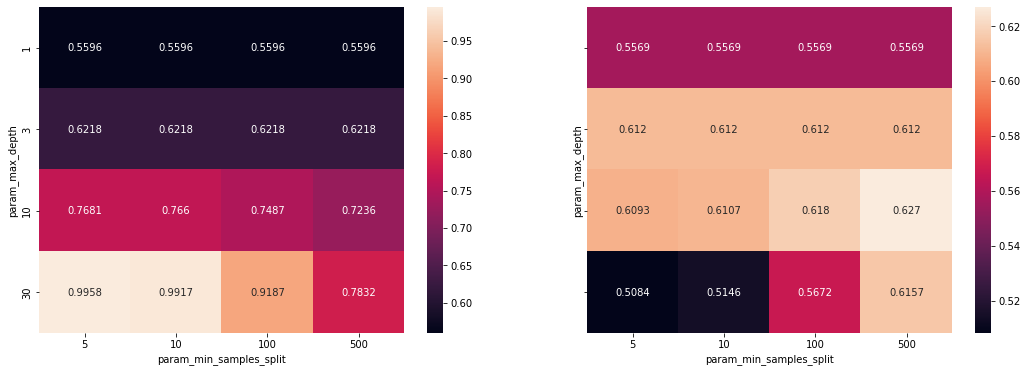

In [95]:
# https://stackoverflow.com/questions/56478320/how-to-create-multiple-seaborn-heatmaps-with-a-shared-legend-in-one-figure
fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(18,6))
sn.heatmap(values_heatmap.mean_train_score, annot=True, fmt='.4g',ax=ax[0]);
sn.heatmap(values_heatmap.mean_test_score, annot=True, fmt='.4g',ax=ax[1]);
plt.show()

# <font color="Black">Using the Best Parameters, fit the model. Plot ROC-AUC curve(using predict proba method)</b></font>

In [96]:
clf = DecisionTreeClassifier(max_depth=search.best_params_['max_depth'],
                              min_samples_split=search.best_params_['min_samples_split'])

In [97]:
clf.fit(train_set_2,y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=500)

In [98]:
train_value = clf.predict_proba(train_set_2)
train_set_2_y = train_value[:,1]
print("train_set_1_y:",train_set_2_y.shape)
test_value = clf.predict_proba(test_set_2)
test_set_2_y = test_value[:,1]
print("test_set_1_y:",test_set_2_y.shape)

train_set_1_y: (73196,)
test_set_1_y: (36052,)


In [99]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_train,train_set_2_y)
Train_AUC = auc(train_fpr, train_tpr)
print("Train AUC:",Train_AUC)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test,test_set_2_y)
Test_AUC = auc(test_fpr, test_tpr)
print("Test AUC:",Test_AUC)

Train AUC: 0.720581626325997
Test AUC: 0.6340100920327459


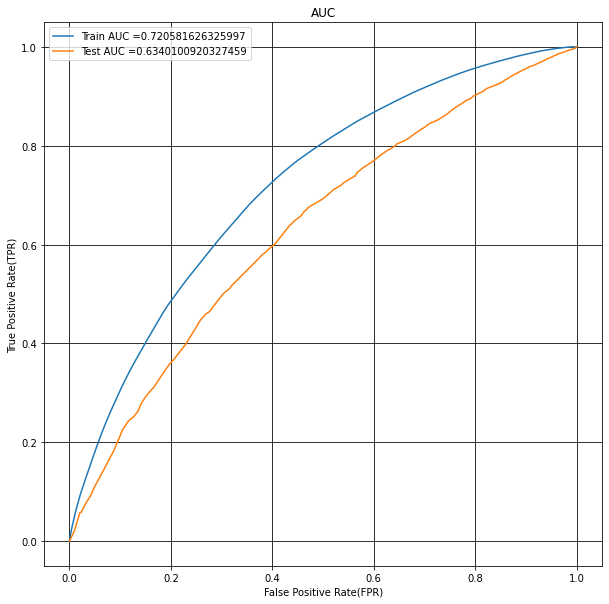

In [100]:
plt.figure(figsize=(10,10))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(Train_AUC))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(Test_AUC))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

# <font color='black'><b>Plot confusion matrix based on best threshold value</b></font>

In [101]:
from sklearn.metrics import confusion_matrix

# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [102]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(train_set_2_y, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(test_set_2_y, best_t)))

the maximum value of tpr*(1-fpr) 0.4396461064298933 for threshold 0.858
Train confusion matrix
[[ 7099  3984]
 [19480 42633]]
Test confusion matrix
[[ 2930  2529]
 [10174 20419]]


Train confusion matrix


Text(33.0, 0.5, 'True')

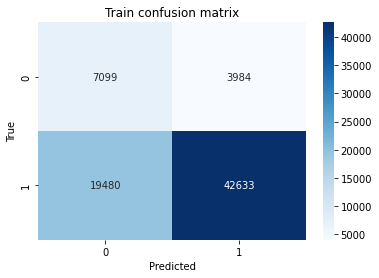

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Train confusion matrix")
plt.title("Train confusion matrix")
sns.heatmap((confusion_matrix(y_train, predict_with_best_t(train_set_2_y, best_t))), annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")

Test confusion matrix


Text(33.0, 0.5, 'True')

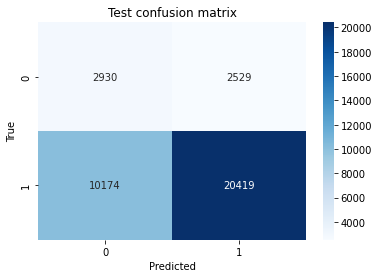

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Test confusion matrix")
plt.title("Test confusion matrix")
sns.heatmap((confusion_matrix(y_test, predict_with_best_t(test_set_2_y, best_t))), annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")

# <font color='black'> <b>Find all the false positive data points and plot wordcloud of essay text and pdf of teacher_number_of_previously_posted_projects.</b></font>

In [105]:
predict_values = predict_with_best_t(test_set_2_y,best_t)

In [106]:
false_pos = []
for x in range(len(y_test)):
    if((y_test[x]==0) and (predict_values[x]==1)):
        false_pos.append(x)  
print("false_pos_shape:",len(false_pos))

features = x_test.columns
false_pos_ds = pd.DataFrame(columns=features)
false_pos_ds = x_test.iloc[false_pos]
print("False_pos_ds:",false_pos_ds.shape)

false_pos_shape: 2529
False_pos_ds: (2529, 12)


In [107]:
features = x_test.columns
false_pos_ds = pd.DataFrame(columns=features)
false_pos_ds = x_test.iloc[false_pos]
print("False_pos_ds:",false_pos_ds.shape)

False_pos_ds: (2529, 12)


# <font color='black'> <b>Plot the WordCloud(https://www.geeksforgeeks.org/generating-word-cloud-python/) with the words of essay text of these `false positive data points</b></font>

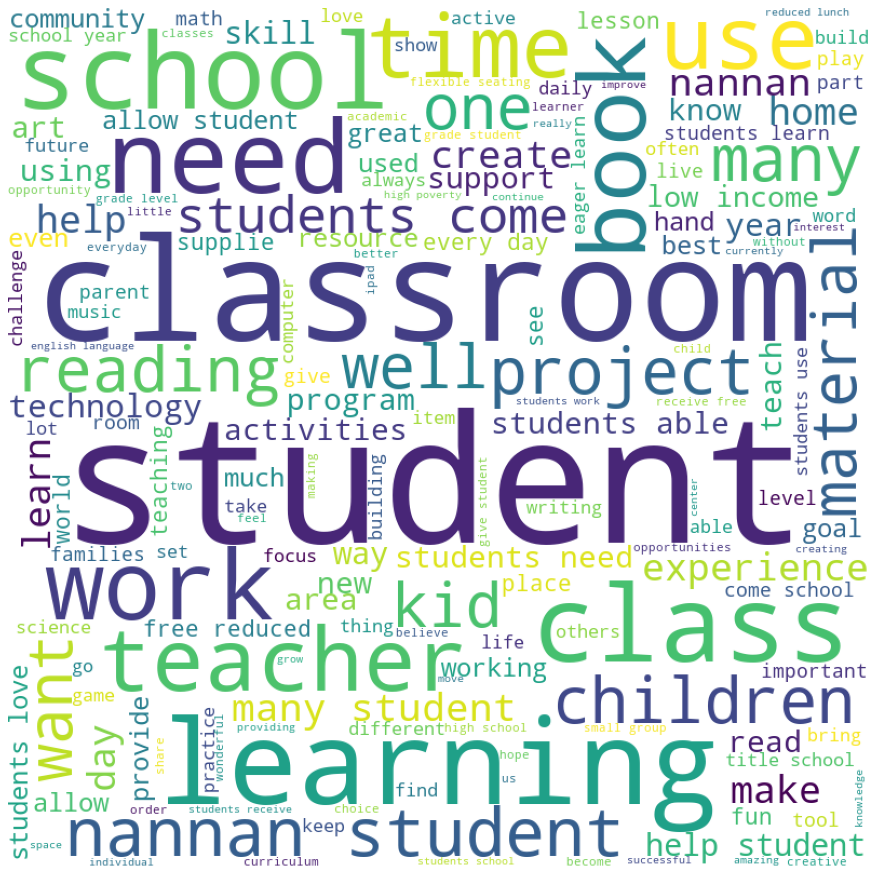

In [108]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ''
stopwords = set(STOPWORDS)
for val in false_pos_ds['essay']: 
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# <font color='black'> <b>Plot the box plot with the `price` of these `false positive data points`</b></font>

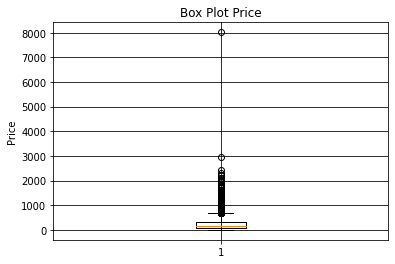

In [109]:
data = false_pos_ds['price']
plt.title("Box Plot Price")
plt.boxplot(data)
plt.grid(True)
plt.ylabel('Price')
plt.show()

# <font color='black'> <b>Plot the pdf with the `teacher_number_of_previously_posted_projects` of these `false positive data points`</b></font>

[8.92447608e-01 5.85211546e-02 2.09569000e-02 1.06761566e-02
 6.32661131e-03 4.74495848e-03 2.37247924e-03 2.37247924e-03
 3.95413207e-04 1.18623962e-03]


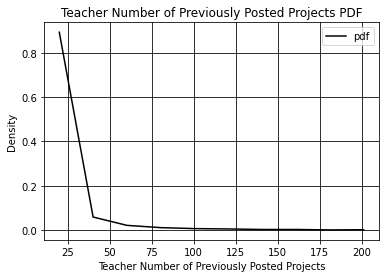

In [110]:
counts, bin_edges = np.histogram(false_pos_ds['teacher_number_of_previously_posted_projects'], bins=10,density = True)
pdf = counts/(sum(counts))
print(pdf)
plt.plot(bin_edges[1:],pdf,label = 'pdf',color='black')
plt.title("Teacher Number of Previously Posted Projects PDF")
plt.grid(True)
plt.xlabel("Teacher Number of Previously Posted Projects")
plt.ylabel("Density")
plt.legend()

# <font color='red'> <b>Task - 2</b></font>

In [111]:
train_set_1 = hstack((essay_tfidf_x_train, OHE_X_train_state, OHE_X_train_teacher_prefix, OHE_X_train_grade_catagory, 
                     OHE_X_train_clean_categories,OHE_X_train_clean_subcategories, scaler_X_train_teacher_number_of_previously_posted_projects,
                     scaler_X_train_price, scaler_X_train_NSS, scaler_X_train_NUSS, scaler_X_train_PSS, scaler_X_train_CSS)).tocsr()
print(train_set_1.shape,  y_train.shape)

test_set_1 = hstack((essay_tfidf_x_test, OHE_X_test_state, OHE_X_test_teacher_prefix, OHE_X_test_grade_catagory, 
                     OHE_X_test_clean_categories,OHE_X_test_clean_subcategories, scaler_X_test_teacher_number_of_previously_posted_projects,
                     scaler_X_test_price, scaler_X_test_NSS, scaler_X_test_NUSS, scaler_X_test_PSS, scaler_X_test_CSS)).tocsr()

print(test_set_1.shape,  y_test.shape)

(73196, 14371) (73196,)
(36052, 14371) (36052,)


In [112]:
param_grid = {'max_depth':[1,3,10,30],'min_samples_split':[5,10,100,500]}

In [113]:
DT = DecisionTreeClassifier(max_depth=None,min_samples_split=500)

In [114]:
DT.fit(train_set_1,y_train)

DecisionTreeClassifier(min_samples_split=500)

In [115]:
features = DT.feature_importances_
len(features)

14371

In [116]:
non_zero_feature = []
for x in range(len(features)):
    if(features[x]>0):
        non_zero_feature.append(features[x])        
print(len(non_zero_feature)) 

2742


In [117]:
new_train_set_1 = train_set_1[:,non_zero_feature]
print(new_train_set_1.shape,y_train.shape)
new_test_set_1 = test_set_1[:,non_zero_feature]
print(new_test_set_1.shape,y_test.shape)

(73196, 2742) (73196,)
(36052, 2742) (36052,)


In [118]:
search = GridSearchCV(DT, param_grid, n_jobs=-1, scoring="roc_auc", cv=3, return_train_score=True)
search.fit(new_train_set_1,y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(min_samples_split=500),
             n_jobs=-1,
             param_grid={'max_depth': [1, 3, 10, 30],
                         'min_samples_split': [5, 10, 100, 500]},
             return_train_score=True, scoring='roc_auc')

In [119]:
score = search.best_score_
print("Best Score:",score)

Best Score: 0.500580705932128


In [120]:
estimator = search.best_estimator_
print("Best Estimator:",estimator)

Best Estimator: DecisionTreeClassifier(max_depth=30, min_samples_split=10)


In [121]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
result = search.cv_results_
mean_train_score = result["mean_train_score"]
mean_test_score  = result['mean_test_score']
print("mean_train_score:",mean_train_score)
print("----------------------------------------------------")
print("mean_test_score:",mean_test_score)

mean_train_score: [0.50018775 0.50018775 0.50018775 0.50018775 0.50070417 0.50070417
 0.50057892 0.50057892 0.50160948 0.50150496 0.50107055 0.50107055
 0.50195192 0.50176713 0.50127965 0.50127965]
----------------------------------------------------
mean_test_score: [0.50007901 0.50007901 0.50007901 0.50007901 0.50011072 0.50011072
 0.49985671 0.49985671 0.50031518 0.50023477 0.5000098  0.5000098
 0.50057725 0.50058071 0.50014337 0.50014337]


In [122]:
x = param_grid['max_depth']
y = param_grid['min_samples_split']
train_auc_z = mean_train_score
test_auc_z = mean_test_score

In [124]:
# https://stackoverflow.com/questions/56302647/how-to-plot-a-heatmap-and-find-best-hyperparameter-for-decision-tree-after-grids
values_heatmap = pd.DataFrame(search.cv_results_)
values_heatmap = values_heatmap.groupby(['param_max_depth','param_min_samples_split']).max()
values_heatmap = values_heatmap.unstack()[['mean_test_score', 'mean_train_score']]
values_heatmap.head()

mean_test_score                                \
param_min_samples_split             5         10        100       500   
param_max_depth                                                         
1                              0.500079  0.500079  0.500079  0.500079   
3                              0.500111  0.500111  0.499857  0.499857   
10                             0.500315  0.500235  0.500010  0.500010   
30                             0.500577  0.500581  0.500143  0.500143   

                        mean_train_score                                
param_min_samples_split              5         10        100       500  
param_max_depth                                                         
1                               0.500188  0.500188  0.500188  0.500188  
3                               0.500704  0.500704  0.500579  0.500579  
10                              0.501609  0.501505  0.501071  0.501071  
30                              0.501952  0.501767  0.501280  0.501280

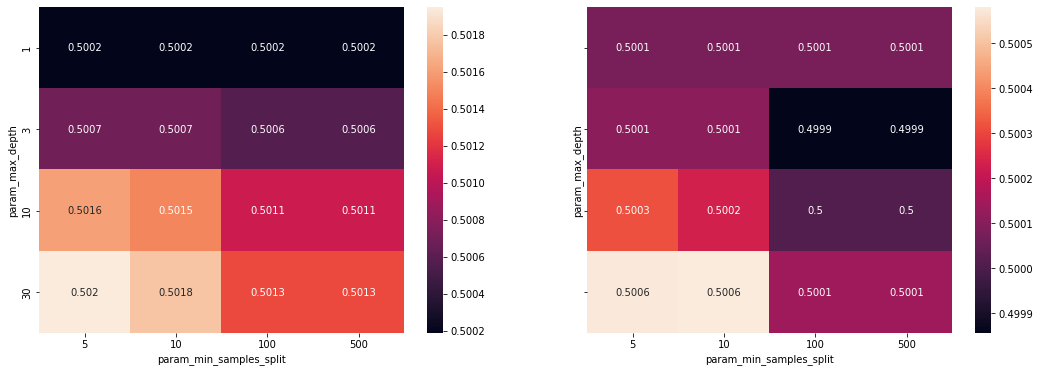

In [125]:
# https://stackoverflow.com/questions/56478320/how-to-create-multiple-seaborn-heatmaps-with-a-shared-legend-in-one-figure
fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(18,6))
sn.heatmap(values_heatmap.mean_train_score, annot=True, fmt='.4g',ax=ax[0]);
sn.heatmap(values_heatmap.mean_test_score, annot=True, fmt='.4g',ax=ax[1]);
plt.show()

In [126]:
clf = DecisionTreeClassifier(max_depth=search.best_params_['max_depth'],
                              min_samples_split=search.best_params_['min_samples_split'])

In [127]:
clf.fit(new_train_set_1,y_train)

DecisionTreeClassifier(max_depth=30, min_samples_split=10)

In [128]:
train_value = clf.predict_proba(new_train_set_1)
new_train_set_1_y = train_value[:,1]
print("new_train_set_1_y:",new_train_set_1_y.shape)
test_value = clf.predict_proba(new_test_set_1)
new_test_set_1_y = test_value[:,1]
print("new_test_set_1_y:",new_test_set_1_y.shape)

new_train_set_1_y: (73196,)
new_test_set_1_y: (36052,)


In [129]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_train,new_train_set_1_y)
Train_AUC = auc(train_fpr, train_tpr)
print("Train AUC:",Train_AUC)
test_fpr, test_tpr, test_thresholds = roc_curve(y_test,new_test_set_1_y)
Test_AUC = auc(test_fpr, test_tpr)
print("Test AUC:",Test_AUC)

Train AUC: 0.5018072703799903
Test AUC: 0.4996731068825199


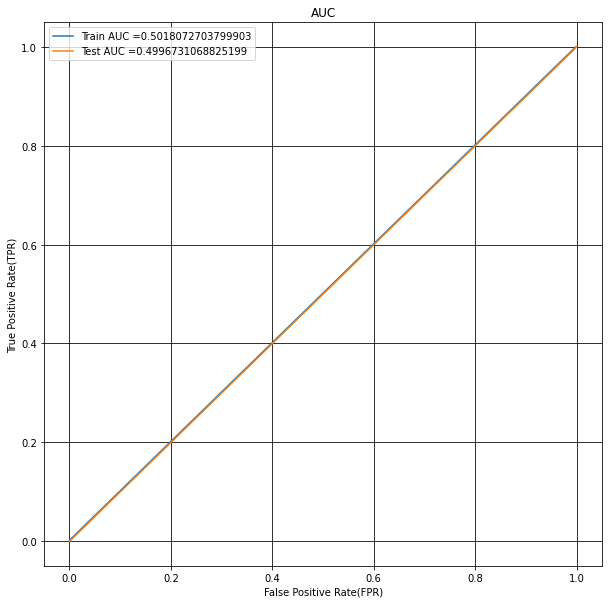

In [130]:
plt.figure(figsize=(10,10))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(Train_AUC))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(Test_AUC))
plt.legend()
plt.ylabel("True Positive Rate(TPR)")
plt.xlabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.rc('grid', linestyle="-", color='black') 
plt.grid(True)
plt.show()

In [132]:
from sklearn.metrics import confusion_matrix

# we are writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [131]:
best_t = find_best_threshold(train_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
print(confusion_matrix(y_train, predict_with_best_t(new_train_set_1_y, best_t)))
print("Test confusion matrix")
print(confusion_matrix(y_test, predict_with_best_t(new_test_set_1_y, best_t)))

the maximum value of tpr*(1-fpr) 0.002345179839535902 for threshold 0.849
Train confusion matrix
[[   26 11057]
 [   20 62093]]
Test confusion matrix
[[    5  5454]
 [   28 30565]]


Train confusion matrix


Text(33.0, 0.5, 'True')

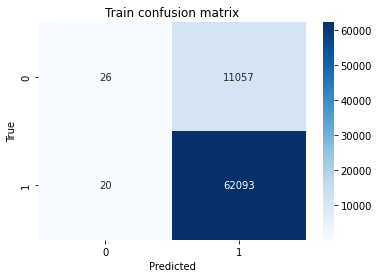

In [133]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Train confusion matrix")
plt.title("Train confusion matrix")
sns.heatmap((confusion_matrix(y_train, predict_with_best_t(new_train_set_1_y, best_t))), annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")

Test confusion matrix


Text(33.0, 0.5, 'True')

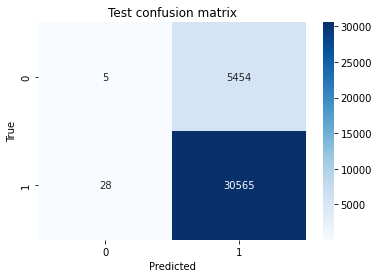

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt  
print("Test confusion matrix")
plt.title("Test confusion matrix")
sns.heatmap((confusion_matrix(y_test, predict_with_best_t(new_test_set_1_y, best_t))), annot=True,fmt="d",cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")

In [135]:
predict_values = predict_with_best_t(new_test_set_1_y,best_t)

In [136]:
false_pos = []
for x in range(len(y_test)):
    if((y_test[x]==0) and (predict_values[x]==1)):
        false_pos.append(x)  
print("false_pos_shape:",len(false_pos))

false_pos_shape: 5454


In [137]:
features = x_test.columns
false_pos_ds = pd.DataFrame(columns=features)
false_pos_ds = x_test.iloc[false_pos]
print("False_pos_ds:",false_pos_ds.shape)

False_pos_ds: (5454, 12)


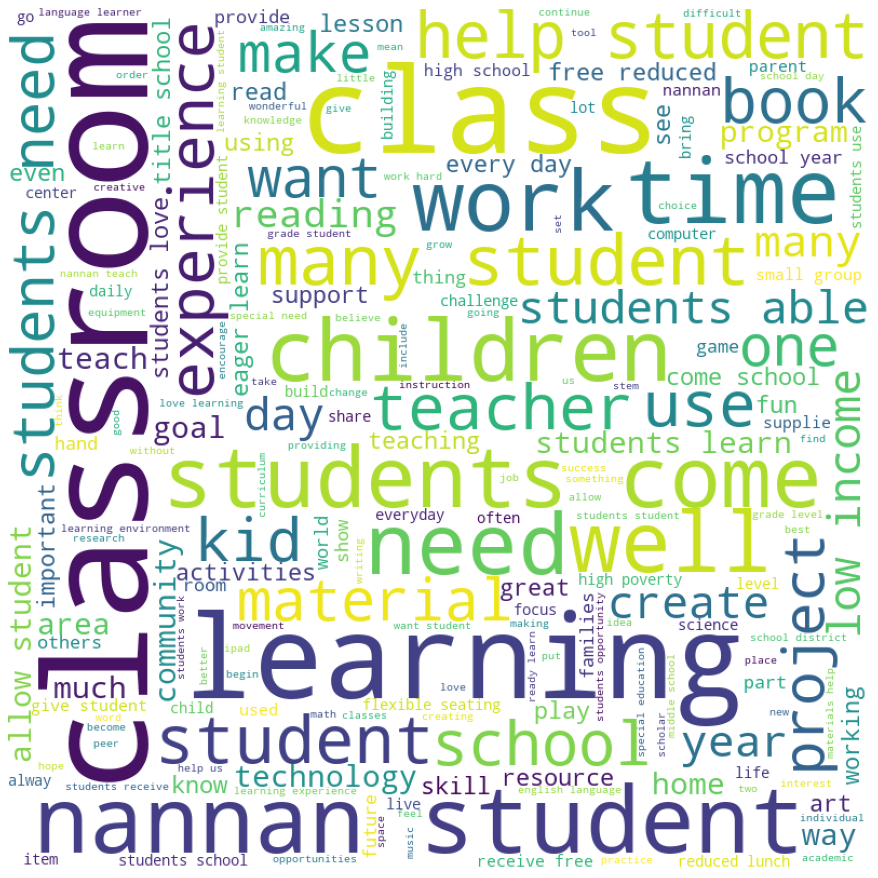

In [138]:
# https://www.geeksforgeeks.org/generating-word-cloud-python/
comment_words = ''
stopwords = set(STOPWORDS)
for val in false_pos_ds['essay']: 
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    comment_words += " ".join(tokens)+" "
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

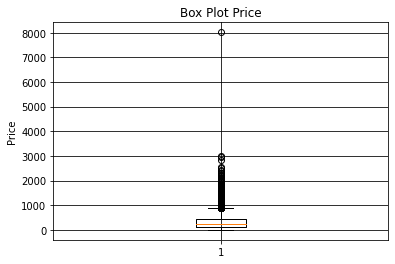

In [139]:
data = false_pos_ds['price']
plt.title("Box Plot Price")
plt.boxplot(data)
plt.grid(True)
plt.ylabel('Price')
plt.show()

[9.31059773e-01 4.32709938e-02 1.24679135e-02 4.76714338e-03
 4.03373671e-03 1.46681335e-03 1.46681335e-03 7.33406674e-04
 3.66703337e-04 3.66703337e-04]


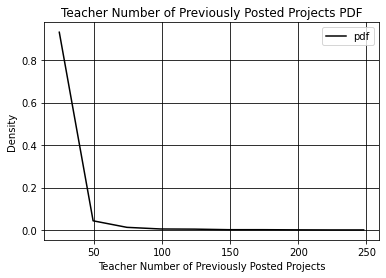

In [140]:
counts, bin_edges = np.histogram(false_pos_ds['teacher_number_of_previously_posted_projects'], bins=10,density = True)
pdf = counts/(sum(counts))
print(pdf)
plt.plot(bin_edges[1:],pdf,label = 'pdf',color='black')
plt.title("Teacher Number of Previously Posted Projects PDF")
plt.grid(True)
plt.xlabel("Teacher Number of Previously Posted Projects")
plt.ylabel("Density")
plt.legend()

In [144]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["S.NO", "Model","Hyper_Parameter","Vectorizer","Train_AUC","Test_AUC"]
x.add_row(["1", "Decision Tree", "max_depth=10, min_samples_split=500", "TFIDF",0.6906169806654935,0.6523688468568721])
x.add_row(["2", "Decision Tree", "max_depth=10, min_samples_split=500", "TFIDF Weight W2V", 0.720581626325997, 0.6340100920327459])
x.add_row(["3", "Decision Tree", "max_depth=30, min_samples_split=10 ", "Non Zero TFIDF Feature",0.5018072703799903,0.4996731068825199])
print(x)

+------+---------------+-------------------------------------+------------------------+--------------------+--------------------+
| S.NO |     Model     |           Hyper_Parameter           |       Vectorizer       |     Train_AUC      |      Test_AUC      |
+------+---------------+-------------------------------------+------------------------+--------------------+--------------------+
|  1   | Decision Tree | max_depth=10, min_samples_split=500 |         TFIDF          | 0.6906169806654935 | 0.6523688468568721 |
|  2   | Decision Tree | max_depth=10, min_samples_split=500 |    TFIDF Weight W2V    | 0.720581626325997  | 0.6340100920327459 |
|  3   | Decision Tree | max_depth=30, min_samples_split=10  | Non Zero TFIDF Feature | 0.5018072703799903 | 0.4996731068825199 |
+------+---------------+-------------------------------------+------------------------+--------------------+--------------------+
